In [1]:
import numpy as np
import cv2
import time
import os
import PIL
import matplotlib


<module 'PIL.Image' from 'C:\\Users\\Krul\\Anaconda3\\lib\\site-packages\\PIL\\Image.py'>

### Helpers

In [2]:
# !rm -rf ./test_Imgs
# !rm -rf ./Card_Imgs
# !rm -rf ./test_Video
# !mkdir test_Imgs
# !mkdir Card_Imgs
# !mkdir test_Video

# # !wget -O test_Imgs/card2.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Test_Imgs/card2.jpg -q --show-progress
# # !wget -O test_Imgs/card3.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Test_Imgs/card3.jpg -q --show-progress
# # !wget -O test_Imgs/card5.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Test_Imgs/card5.jpg -q --show-progress
# # !wget -O test_Imgs/card6.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Test_Imgs/card6.jpg -q --show-progress
# !wget -O test_Imgs/newcard1.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Test_Imgs/newcard1.jpg -q --show-progress
# !wget -O test_Imgs/newcard2.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Test_Imgs/newcard2.jpg -q --show-progress
# !wget -O test_Imgs/newcard3.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Test_Imgs/newcard3.jpg -q --show-progress


# !wget -O Card_Imgs/Hearts.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Hearts.jpg -q --show-progress
# !wget -O Card_Imgs/Clubs.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Clubs.jpg -q --show-progress
# !wget -O Card_Imgs/Diamonds.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Diamonds.jpg -q --show-progress
# !wget -O Card_Imgs/Spades.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Spades.jpg -q --show-progress

# !wget -O Card_Imgs/Ace.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Ace.jpg -q --show-progress
# !wget -O Card_Imgs/Two.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Two.jpg -q --show-progress
# !wget -O Card_Imgs/Three.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Three.jpg -q --show-progress
# !wget -O Card_Imgs/Four.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Four.jpg -q --show-progress
# !wget -O Card_Imgs/Five.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Five.jpg -q --show-progress
# !wget -O Card_Imgs/Six.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Six.jpg -q --show-progress
# !wget -O Card_Imgs/Seven.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Seven.jpg -q --show-progress
# !wget -O Card_Imgs/Eight.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Eight.jpg -q --show-progress
# !wget -O Card_Imgs/Nine.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Nine.jpg -q --show-progress
# !wget -O Card_Imgs/Ten.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Ten.jpg -q --show-progress
# !wget -O Card_Imgs/Jack.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Jack.jpg -q --show-progress
# !wget -O Card_Imgs/Queen.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/Queen.jpg -q --show-progress
# !wget -O Card_Imgs/King.jpg https://raw.githubusercontent.com/maslana146/BlackJack-detection/main/Card_Imgs/King.jpg -q --show-progress

# !wget -O test_Video/video1.mp4 https://github.com/maslana146/BlackJack-detection/blob/main/Test_Video/video1.mp4?raw=true -q --show-progress

In [22]:
def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

### Const

In [76]:
#Image size cons.
IM_WIDTH = 1920
IM_HEIGHT = 1080

# Adaptive threshold levels
BKG_THRESH = 60
CARD_THRESH = 30

# Width and height of card corner, where rank and suit are
CORNER_WIDTH = 32
CORNER_HEIGHT = 84

# Dimensions of rank train images
RANK_WIDTH = 70
RANK_HEIGHT = 125

# Dimensions of suit train images
SUIT_WIDTH = 70
SUIT_HEIGHT = 100

RANK_DIFF_MAX = 2000
SUIT_DIFF_MAX = 700

CARD_MAX_AREA = 200000
CARD_MIN_AREA = 20000

font = cv2.FONT_HERSHEY_SIMPLEX

### Classes and loaders

In [77]:
class Query_card:
    """Structure to store information about query cards in the camera image."""

    def __init__(self):
        self.contour = [] # Contour of card
        self.width, self.height = 0, 0 # Width and height of card
        self.corner_pts = [] # Corner points of card
        self.center = [] # Center point of card
        self.warp = [] # 200x300, flattened, grayed, blurred image
        self.rank_img = [] # Thresholded, sized image of card's rank
        self.suit_img = [] # Thresholded, sized image of card's suit
        self.best_rank_match = "Unknown" # Best matched rank
        self.best_suit_match = "Unknown" # Best matched suit
        self.rank_diff = 0 # Difference between rank image and best matched train rank image
        self.suit_diff = 0 # Difference between suit image and best matched train suit image
        self.half = None
        self.size = 0

    def __call__(self):
      return self.best_rank_match + ' of ' + self.best_suit_match + ' with center in ' + str(self.center[0]) +', '+str(self.center[1]) + ' so on ' + self.half + ' half'


class Train_ranks:
    """Structure to store information about train rank images."""

    def __init__(self):
        self.img = [] # Thresholded, sized rank image loaded from hard drive
        self.name = "Placeholder"

class Train_suits:
    """Structure to store information about train suit images."""

    def __init__(self):
        self.img = [] # Thresholded, sized suit image loaded from hard drive
        self.name = "Placeholder"

In [78]:
def load_ranks(filepath):
    """Loads rank images from directory specified by filepath. Stores
    them in a list of Train_ranks objects."""

    train_ranks = []
    i = 0
    
    for Rank in ['Ace','Two','Three','Four','Five','Six','Seven',
                 'Eight','Nine','Ten','Jack','Queen','King']:
        train_ranks.append(Train_ranks())
        train_ranks[i].name = Rank
        filename = Rank + '.jpg'
        # print(filepath+filename)
        train_ranks[i].img = cv2.imread(filepath+filename, cv2.IMREAD_GRAYSCALE)
        i = i + 1

    return train_ranks


In [79]:
def load_suits(filepath):
    """Loads suit images from directory specified by filepath. Stores
    them in a list of Train_suits objects."""

    train_suits = []
    i = 0
    
    for Suit in ['Spades','Diamonds','Clubs','Hearts']:
        train_suits.append(Train_suits())
        train_suits[i].name = Suit
        filename = Suit + '.jpg'
        train_suits[i].img = cv2.imread(filepath+filename, cv2.IMREAD_GRAYSCALE)
        i = i + 1

    return train_suits

### Functions

In [80]:
def preprocess_image(image):
    """Returns a grayed, blurred, and adaptively thresholded camera image."""

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(9,9),0)
    
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, 8)

    return thresh

In [126]:
def find_cards(thresh_image):
    """Finds all card-sized contours in a thresholded camera image.
    Returns the number of cards, and a list of card contours sorted
    from largest to smallest."""

    # Find contours and sort their indices by contour size
    cnts, hier = cv2.findContours(thresh_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    index_sort = sorted(range(len(cnts)), key=lambda i : cv2.contourArea(cnts[i]),reverse=True)

    # If there are no contours, do nothing
    if len(cnts) == 0:
        return [], []

    # Determine which of the contours are cards by applying the
    # following criteria: 1) Smaller area than the maximum card size,
    # 2), bigger area than the minimum card size, 3) have no parents,
    # and 4) have four corners
    finnal_cnts = []
    for i in range(len(cnts)):
        size = cv2.contourArea(cnts[i])
        peri = cv2.arcLength(cnts[i], True)
        approx = cv2.approxPolyDP(cnts[i], 0.01*peri, True)
        # print(size, len(approx), hier[0][i][3])
        if( (size < CARD_MAX_AREA) and (size > CARD_MIN_AREA) and (len(approx) == 4) and (hier[0][i][3] == -1 )):
            finnal_cnts.append(cnts[i])
    return finnal_cnts

In [108]:
def preprocess_card(contour, image, show = True):
  
    """Uses contour to find information about the query card. Isolates rank
        and suit images from the card."""

    # Initialize new Query_card object
    qCard = Query_card()
    qCard.contour = contour
    
    #save size for future
    size = cv2.contourArea(contour)
    qCard.size = size
    
    # Find perimeter of card and use it to approximate corner points
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.01*peri,True)
    pts = np.float32(approx)
    qCard.corner_pts = pts

    # Find width and height of card's bounding rectangle
    x,y,w,h = cv2.boundingRect(contour)
    ##########################################################        
    if show: image_copy = image.copy()
    if show: cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
    if show: imshow(image_copy)
    

    qCard.width, qCard.height = w, h

    # Find center point of card by taking x and y average of the four corners.
    average = np.sum(pts, axis=0)/len(pts)
    cent_x = int(average[0][0])
    cent_y = int(average[0][1])
    qCard.center = [cent_x, cent_y]
    if cent_y > IM_HEIGHT/2:
        qCard.half = 'bottom'
    else: qCard.half = 'top'

    # Warp card into 200x300 flattened image using perspective transform
    # testa = (image.copy(), pts, w, h)
    qCard.warp = flattener(image, pts, w, h)
    if show: imshow(qCard.warp)

    # Grab corner of warped card image and do a 4x zoom
    Qcorner = qCard.warp[0:CORNER_HEIGHT, 0:CORNER_WIDTH]
    Qcorner_zoom = cv2.resize(Qcorner, (0,0), fx=4, fy=4)
    if show: imshow(Qcorner_zoom)
    # Sample known white pixel intensity to determine good threshold level

    # this adaptiveThreshold may need some tunning
    query_thresh = cv2.adaptiveThreshold(Qcorner_zoom, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 91, 8)
    
    if show: imshow(query_thresh)
    
    # Split in to top and bottom half (top shows rank, bottom shows suit)
    Qrank = query_thresh[20:195, 0:128]
    Qsuit = query_thresh[195:336, 0:128]

    if show: print('##########################################################')
    if show: imshow(Qrank)
    if show: print('##########################################################')
    if show: imshow(Qsuit)

    qCard.rank_img = find_bounds(Qrank, RANK_WIDTH, RANK_HEIGHT)#Qrank_sized
    qCard.suit_img = find_bounds(Qsuit, SUIT_WIDTH, SUIT_HEIGHT)
   
    if show: print('##########################################################')
    if show: imshow(qCard.rank_img)
    if show: print('##########################################################')
    if show: imshow(qCard.suit_img)
    return qCard

In [109]:
def find_bounds(Q, WIDTH, HEIGHT):
    """Find countour and bounding rectangle, isolate and find largest contour and use 
        it to resize image to match dimensions"""
        
    cnts, hier = cv2.findContours(Q, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    if len(cnts) != 0:
        x, y, w, h = cv2.boundingRect(cnts[0])
        roi = Q[y:y+h, x:x+w]
        sized = cv2.resize(roi, (WIDTH, HEIGHT), 0, 0)
        return sized
    return []

### Matching

In [110]:
def match_card(qCard, train_ranks, train_suits):
    """Finds best rank and suit matches for the query card. Differences
    the query card rank and suit images with the train rank and suit images.
    The best match is the rank or suit image that has the least difference."""

    best_rank_match_diff = 10000
    best_suit_match_diff = 10000
    best_rank_match_name = "Unknown"
    best_suit_match_name = "Unknown"
    i = 0

    # If no contours were found in query card in preprocess_card function,
    # the img size is zero, so skip the differencing process
    # (card will be left as Unknown)


    if (len(qCard.rank_img) != 0) and (len(qCard.suit_img) != 0):

        best_rank_name, best_rank_match_diff = find_most_simmilar(qCard.rank_img, train_ranks)
        best_suit_name, best_suit_match_diff = find_most_simmilar(qCard.suit_img, train_suits)
        

    # Combine best rank match and best suit match to get query card's identity.
    # If the best matches have too high of a difference value, card identity
    # is still Unknown
    if (best_rank_match_diff < RANK_DIFF_MAX):
        best_rank_match_name = best_rank_name

    if (best_suit_match_diff < SUIT_DIFF_MAX):
        best_suit_match_name = best_suit_name

    # Return the identiy of the card and the quality of the suit and rank match
    return best_rank_match_name, best_suit_match_name, best_rank_match_diff, best_suit_match_diff

In [111]:
def find_most_simmilar(image, train_set):
    """ Difference the query card image from each of the train images,
        and return the result with the least difference """
    best_match_diff = 10000
    best_name = "Unknown"

    for element in train_set:

        diff_img = cv2.absdiff(image, element.img)
        diff = int(np.sum(diff_img)/255)
        
        if diff < best_match_diff:
            # best_diff_img = diff_img
            best_match_diff = diff
            best_name = element.name
    return best_name, best_match_diff

In [112]:
def draw_results(image, qCard):
    """Draw the card name, center point, and contour on the camera image."""

    x = qCard.center[0]
    y = qCard.center[1]
    rank_name = qCard.best_rank_match
    suit_name = qCard.best_suit_match

    if rank_name != "Unknown" or suit_name != "Unknown":
#         cv2.putText(image,('Rewers'),(x-60,y-10),font,1,(0,0,0),4,cv2.LINE_AA)
#         cv2.putText(image,('Rewers'),(x-60,y-10),font,1,(120,87,32),2,cv2.LINE_AA)
#         pass
#     else: 
        cv2.circle(image,(x,y),5,(255,0,0),-1)

        # Draw card name twice, so letters have black outline
        cv2.putText(image,(rank_name+' of'),(x-60,y-10),font,1,(0,0,0),4,cv2.LINE_AA)
        cv2.putText(image,(rank_name+' of'),(x-60,y-10),font,1,(120,87,32),2,cv2.LINE_AA)

        cv2.putText(image,suit_name,(x-60,y+25),font,1,(0,0,0),4,cv2.LINE_AA)
        cv2.putText(image,suit_name,(x-60,y+25),font,1,(120,87,32),2,cv2.LINE_AA)
    
    return image

In [113]:
def find_corners(pts, w, h):
    ''' From un ordered cornner points, return order cornner points ''' 

    temp_rect = np.zeros((4,2), dtype = "float32")

    s = np.sum(pts, axis = 2)
    # top left corner have smaller sum
    top_left = pts[np.argmin(s)]
    # bottom_left corner have smaller sum
    bottom_right = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    # top right cornner have smaller diffrence
    top_right = pts[np.argmin(diff)]
    # bottom left cornner have smaller diffrence
    bottom_left = pts[np.argmax(diff)]

    if w <= 0.8*h: # If card is vertically oriented
        temp_rect[0] = top_left
        temp_rect[1] = top_right
        temp_rect[2] = bottom_right
        temp_rect[3] = bottom_left

    elif w >= 1.2*h: # If card is horizontally oriented
        temp_rect[0] = bottom_left
        temp_rect[1] = top_left
        temp_rect[2] = top_right
        temp_rect[3] = bottom_right
    
    else: #If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if pts[1][0][1] <= pts[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            temp_rect[0] = pts[1][0] # Top left
            temp_rect[1] = pts[0][0] # Top right
            temp_rect[2] = pts[3][0] # Bottom right
            temp_rect[3] = pts[2][0] # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        else:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            temp_rect[0] = pts[0][0] # Top left
            temp_rect[1] = pts[3][0] # Top right
            temp_rect[2] = pts[2][0] # Bottom right
            temp_rect[3] = pts[1][0] # Bottom left

    return temp_rect

In [114]:
def flattener(image, pts, w, h):
    # print(pts)
    """Flattens an image of a card into a top-down 200x300 perspective.
    Returns the flattened, re-sized, grayed image.
    See www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/"""

    corrner_points = find_corners(pts, w, h)        
        
    maxWidth = 200
    maxHeight = 300

    # Create destination array, calculate perspective transform matrix,
    # and warp card image
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
    M = cv2.getPerspectiveTransform(corrner_points, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warp = cv2.cvtColor(warp,cv2.COLOR_BGR2GRAY)

    return warp

### Main (New)

Regular image


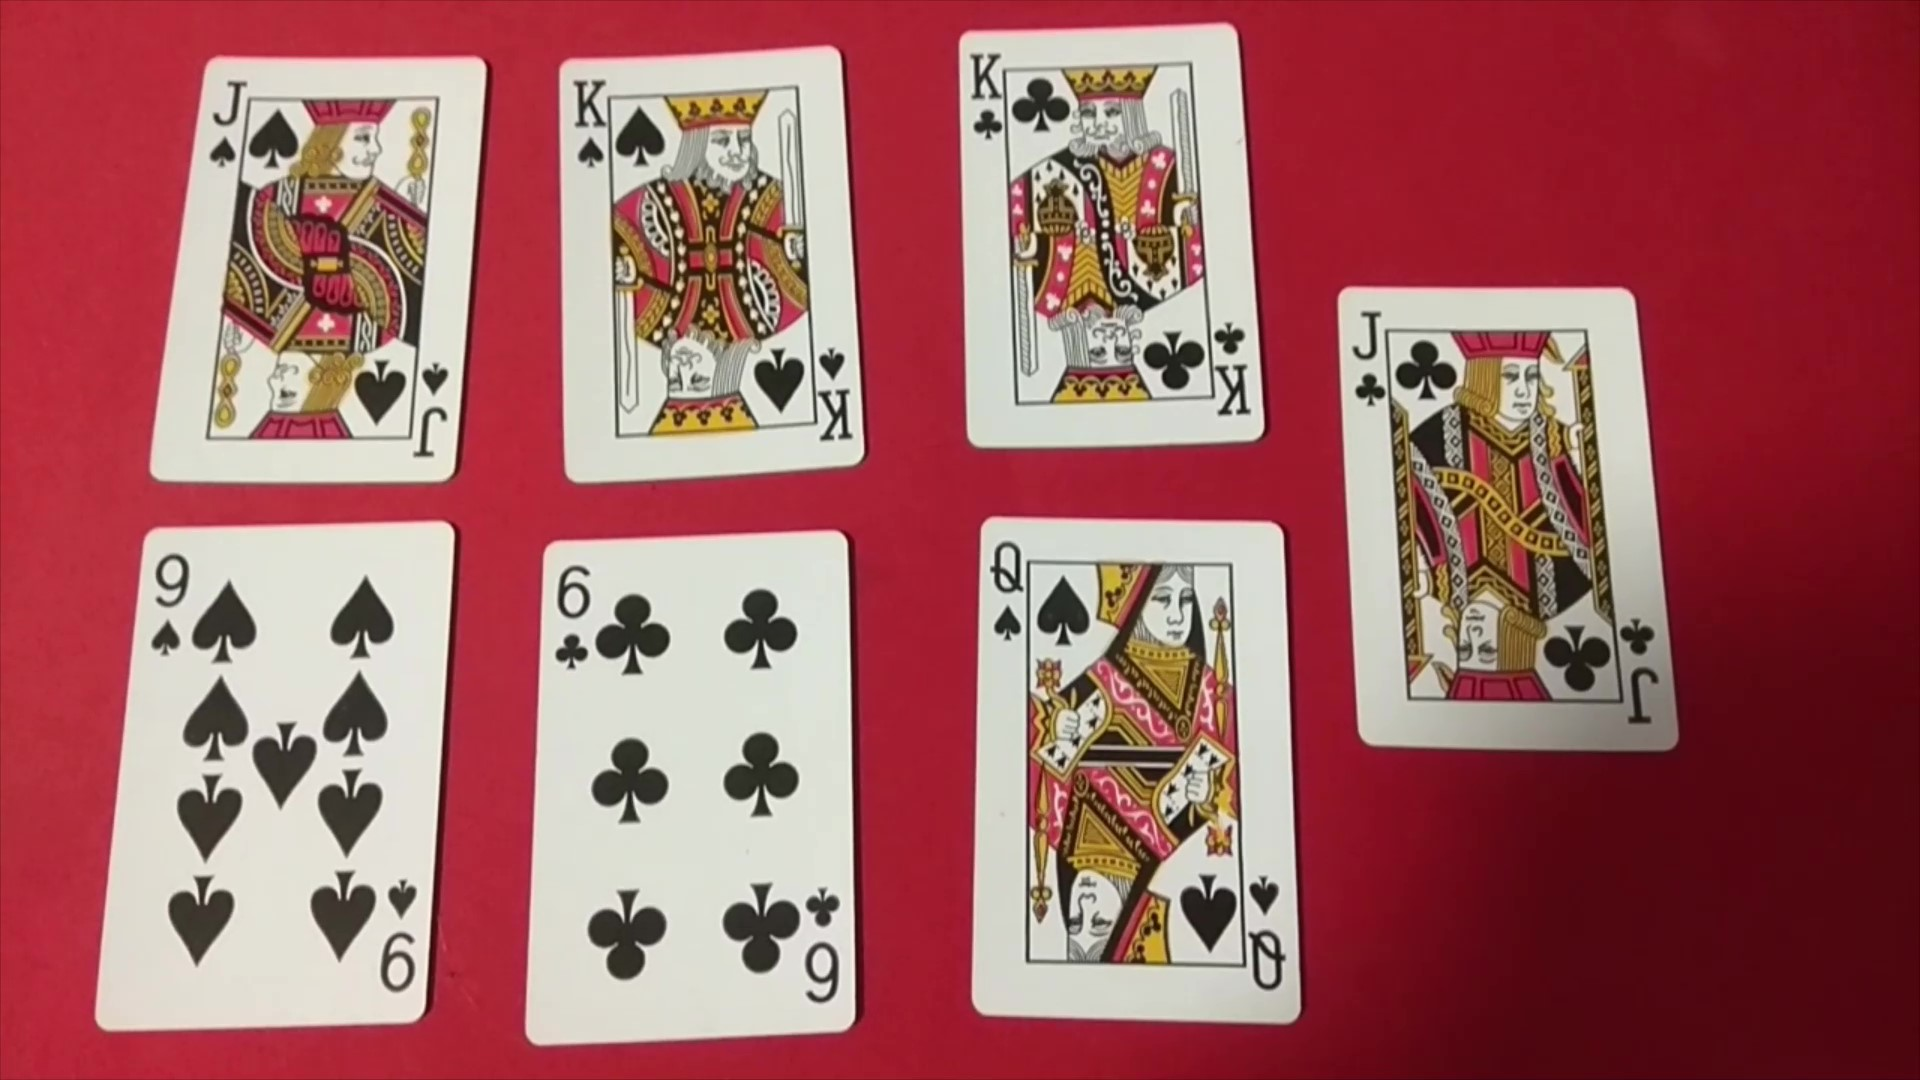

Preprocess image


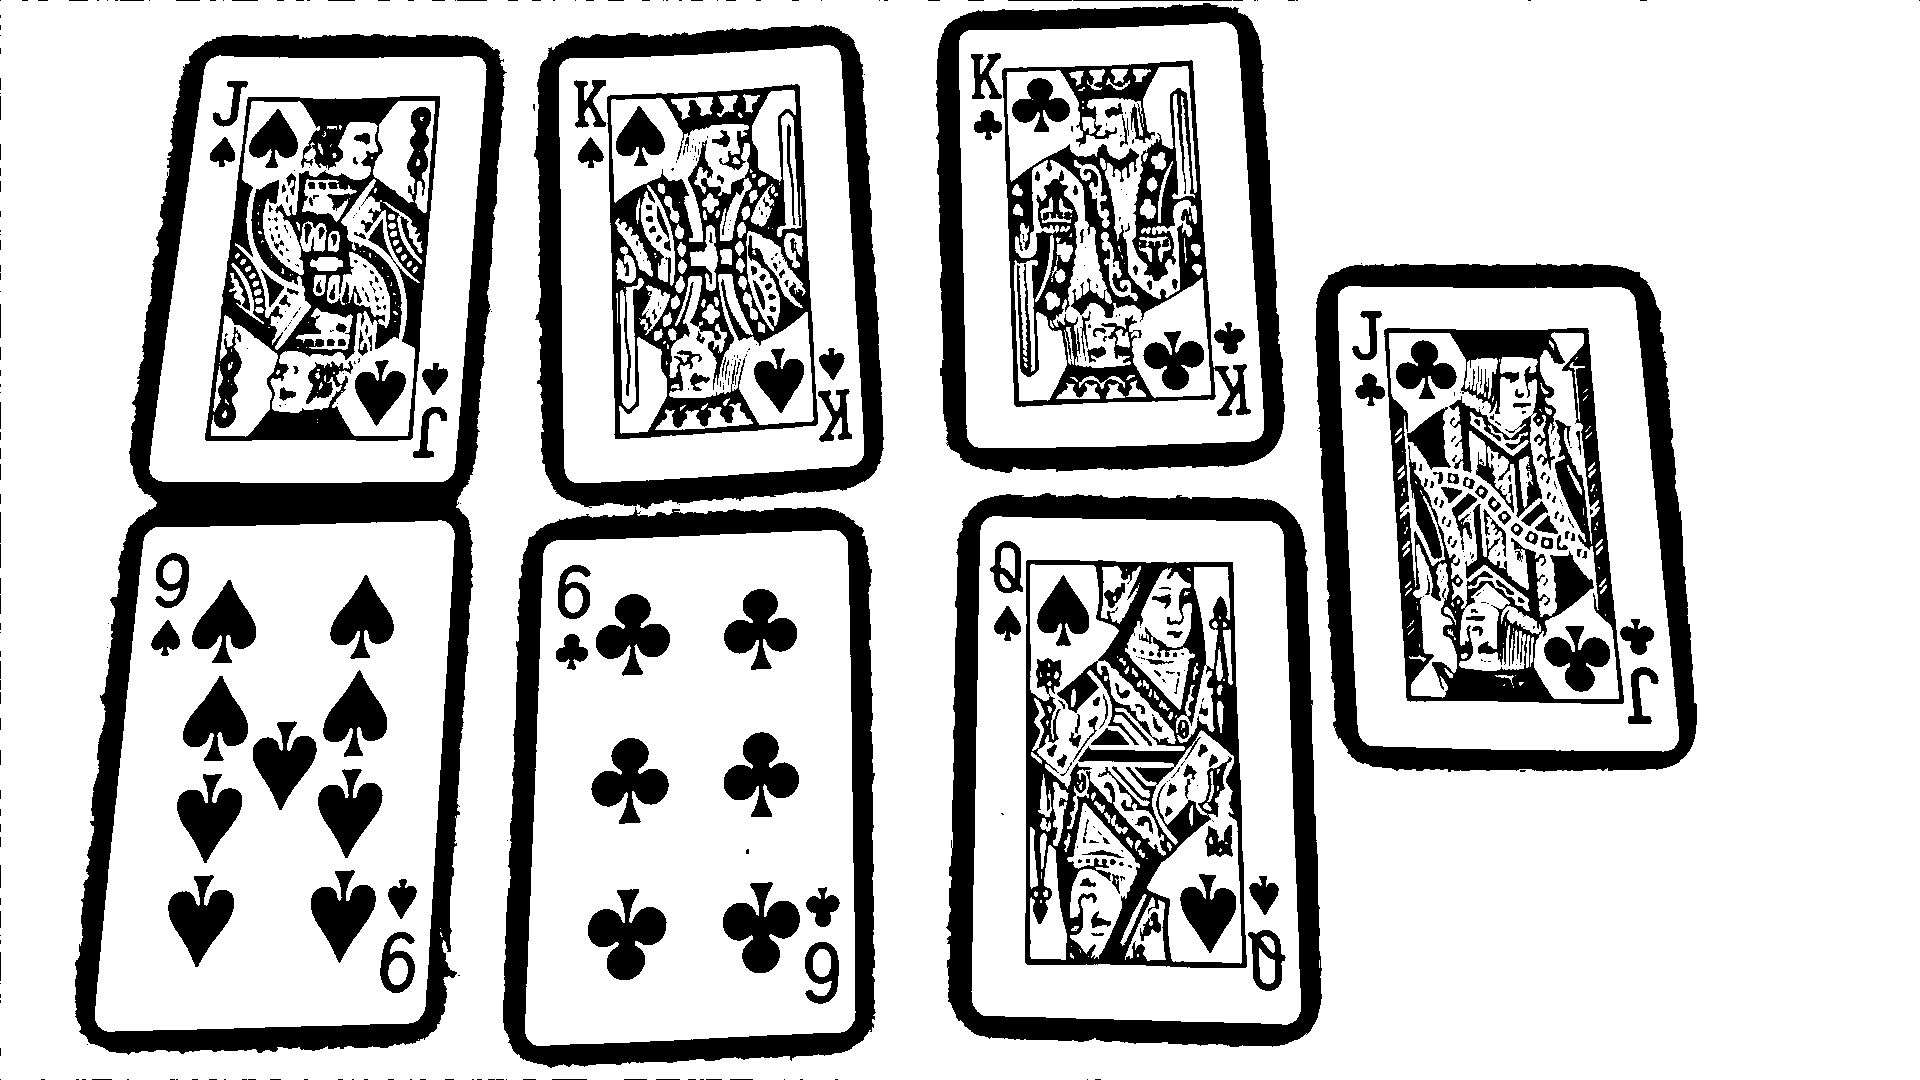

11

In [89]:
train_ranks = load_ranks('Card_Imgs/')
train_suits = load_suits('Card_Imgs/')

image = cv2.imread('test_Imgs/static_Moment.jpg')
print('Regular image')
imshow(image)
pre_proc = preprocess_image(image)
print('Preprocess image')
imshow(pre_proc)
card_cnts = find_cards(pre_proc)
len(card_cnts)

In [90]:
if len(card_cnts) != 0:

        # Initialize a new "cards" list to assign the card objects.
        # k indexes the newly made array of cards.
        cards = []
        k = 0

        # For each contour detected:
        for i in range(len(card_cnts)):
            

            # Create a card object from the contour and append it to the list of cards.
            # preprocess_card function takes the card contour and contour and
            # determines the cards properties (corner points, etc). It generates a
            # flattened 200x300 image of the card, and isolates the card's
            # suit and rank from the image.
            cards.append(preprocess_card(card_cnts[i], image, False))

            # Find the best rank and suit match for the card.
            cards[k].best_rank_match, cards[k].best_suit_match, cards[k].rank_diff, cards[k].suit_diff = match_card(cards[k],train_ranks,train_suits)

            # Draw center point and match result on the image.
            image = draw_results(image, cards[k])
            k = k + 1

        # Draw card contours on image (have to do contours all at once or
        # they do not show up properly for some reason)
        if (len(cards) != 0):
            temp_cnts = []
            for i in range(len(cards)):
                temp_cnts.append(cards[i].contour)
            cv2.drawContours(image,temp_cnts, -1, (255,0,0), 2)

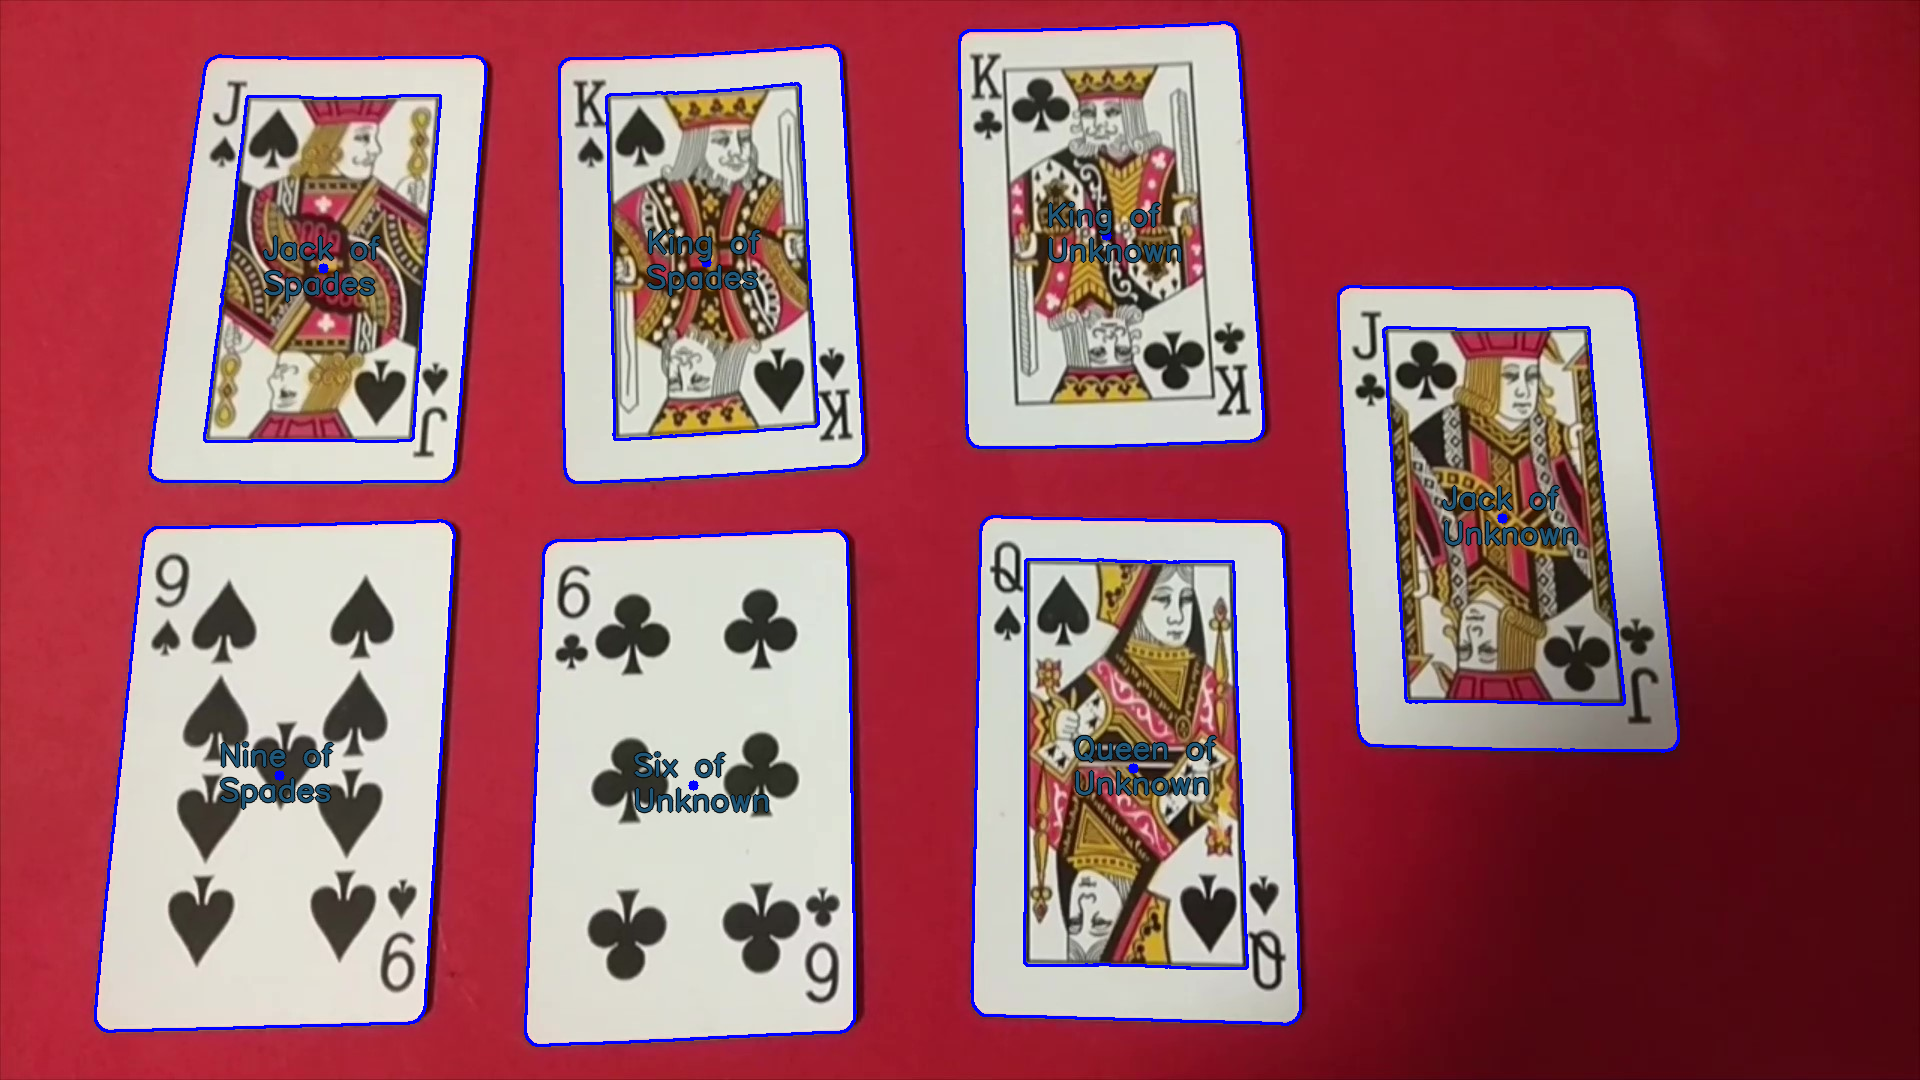

In [91]:
imshow(image)

In [92]:
print(cards[0]())

Six of Unknown with center in 693, 785 so on bottom half


In [62]:
total = 0
for card in cards:
    if card.half == 'bottom':
        if card.best_rank_match ==  'Two':
            total += 2
        elif card.best_rank_match ==  'Three':
            total += 3
        elif card.best_rank_match ==  'Four':
            total += 4
        elif card.best_rank_match ==  'Five':
            total += 5
        elif card.best_rank_match ==  'Six':
            total += 6
        elif card.best_rank_match ==  'Seven':
            total += 7
        elif card.best_rank_match ==  'Eight':
            total += 8
        elif card.best_rank_match ==  'Nine':
            total += 9
        elif (card.best_rank_match ==  'Jack' or card.best_rank_match ==  'Queen' 
        or card.best_rank_match ==  'King' or card.best_rank_match ==  'Ace' or card.best_rank_match ==  'Ten'):
            total += 10
print(total)

35


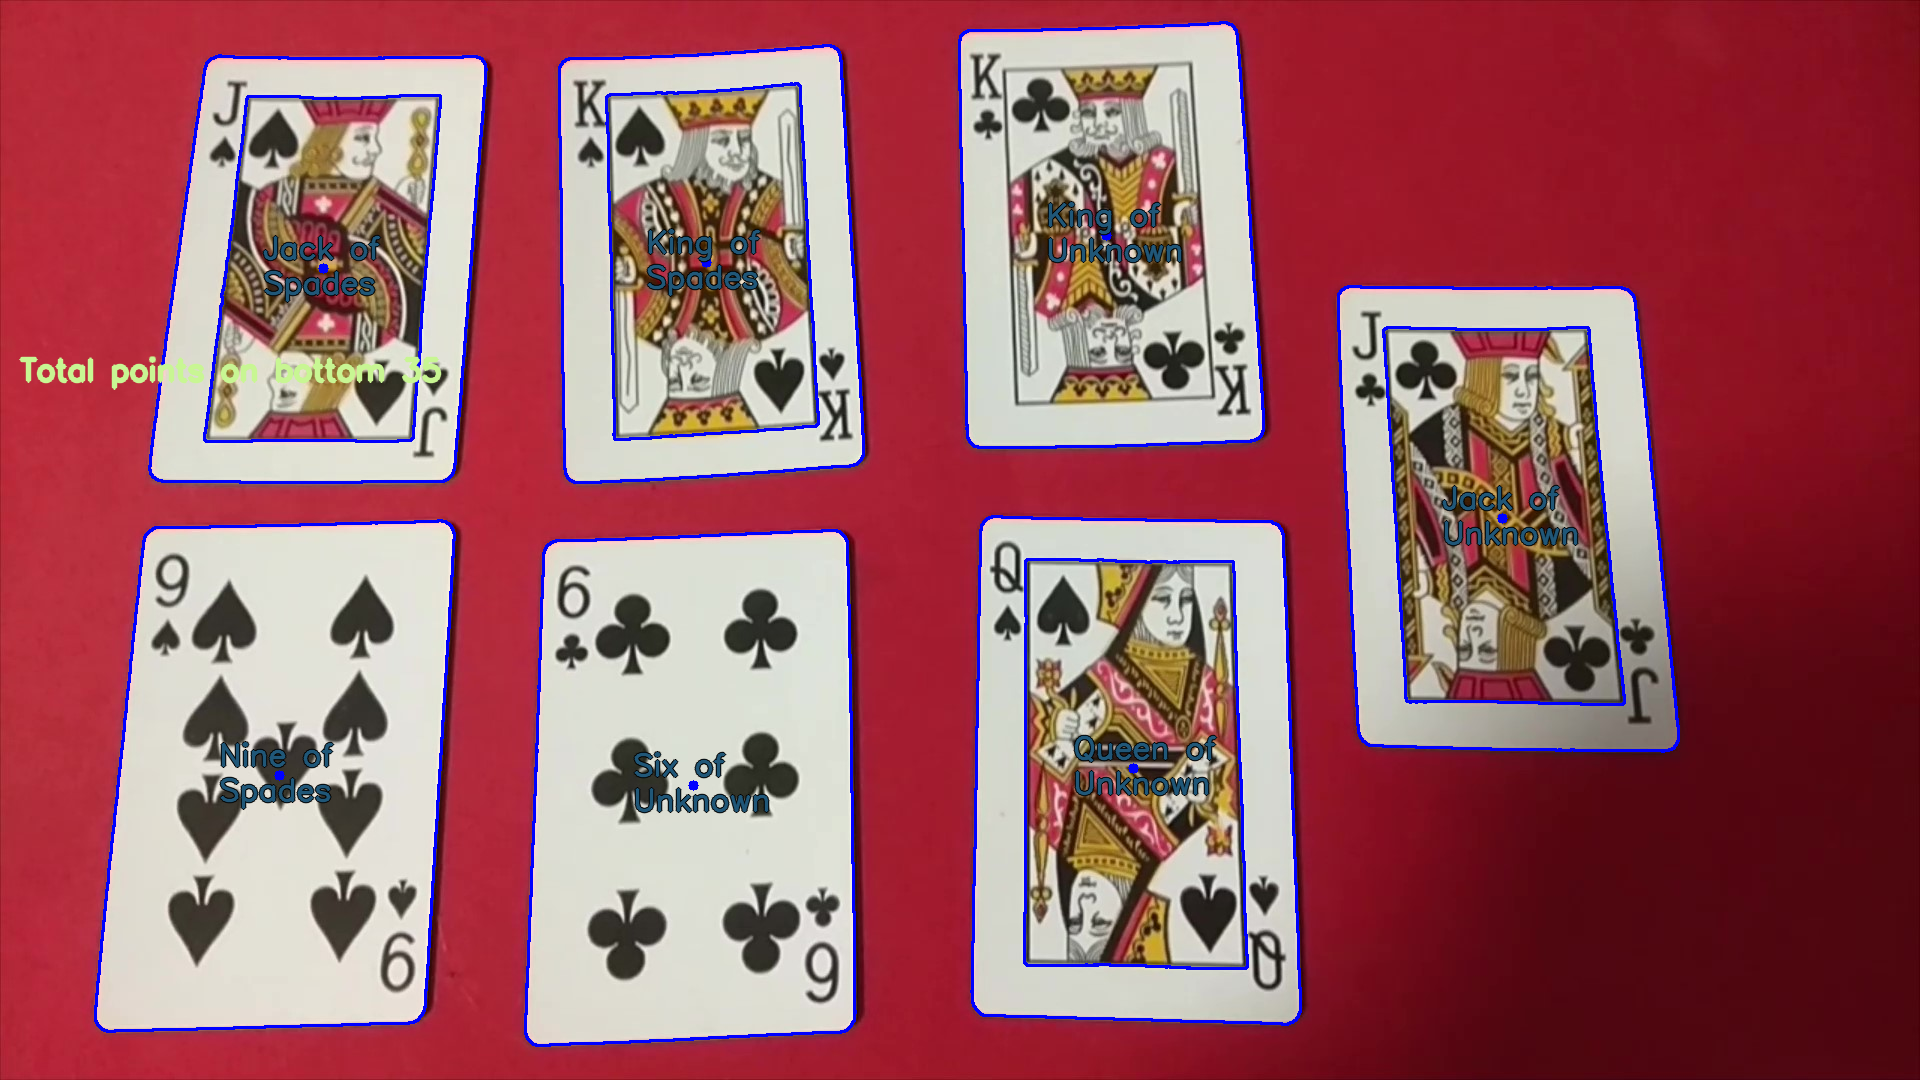

In [63]:
image_copy = image.copy()
cv2.putText( image_copy, ('Total points on bottom ' + str(total)),(20, IM_HEIGHT//2 + 20),font,1,(147,246,200),3,cv2.LINE_AA)
imshow(image_copy)

In [64]:
total = 0
for card in cards:
    if card.half == 'top':
        if card.best_rank_match ==  'Two':
            total += 2
        elif card.best_rank_match ==  'Three':
            total += 3
        elif card.best_rank_match ==  'Four':
            total += 4
        elif card.best_rank_match ==  'Five':
            total += 5
        elif card.best_rank_match ==  'Six':
            total += 6
        elif card.best_rank_match ==  'Seven':
            total += 7
        elif card.best_rank_match ==  'Eight':
            total += 8
        elif card.best_rank_match ==  'Nine':
            total += 9
        else:
            total += 10
print(total)

50


### Video

In [117]:
def f(frame):
#     image = frame.copy()
    pre_proc = preprocess_image(frame)
    card_cnts = find_cards(pre_proc)
    cards = []
    if len(card_cnts) != 0:
        
#         k = 0
        for i in range(len(card_cnts)):
            cards.append(preprocess_card(card_cnts[i], frame, False))
                         
            cards[i].best_rank_match, cards[i].best_suit_match, cards[i].rank_diff, cards[i].suit_diff = match_card(cards[i], train_ranks, train_suits)

            frame = draw_results(frame, cards[i])
#             k = k + 1

        if (len(cards) != 0):
            temp_cnts = []
            for i in range(len(cards)):
                temp_cnts.append(cards[i].contour)
            cv2.drawContours(frame,temp_cnts, -1, (255,0,0), 2)
    
    return frame, cards

In [127]:
cap = cv2.VideoCapture('Test_Video/test2.mp4')

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output2.2.mp4', fourcc, 30.0, (1920, 1080))
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
#     gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
#     cv.imshow('frame', gray)
#     frame = cv2.flip(frame, 0)
    frame, cards = f(frame)

    out.write(frame)



    if cv2.waitKey(1) == ord('q'):
        break
# imshow(frame)
cap.release()
out.release()
# cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
